<a href="https://colab.research.google.com/github/LarsMonstad/AMT-evaluation/blob/main/MusScribeF1Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pretty_midi
!pip install mir_eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=ae7f9c9f808994491545990064c3ffdbd104d8b33cb6bd1a6a4ce17c01d82dcd
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100699 sha256=0f258b447a904cf002f668fd7800f812003d8be46f28286c9cefa306856fb465
  Stored in directory: /root/.cache/pip/wheels/7a/37/52/2a4c9f90d1b3414709ae2fe4627b3c13894f8922d3aade1f9e
Successfully built mir_eval


In [2]:
!git clone https://github.com/LarsMonstad/AMT-evaluation.git

Cloning into 'AMT-evaluation'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 212 (delta 17), reused 3 (delta 0), pack-reused 149 (from 1)
Receiving objects: 100% (212/212), 445.42 KiB | 4.79 MiB/s, done.
Resolving deltas: 100% (19/19), done.


Model                |     Activation     |     Note Onset     |   Note w/ Offset  
                     |  P(%)  R(%) F1(%)  |  P(%)  R(%) F1(%)  |  P(%)  R(%) F1(%) 
------------------------------------------------------------------------------------
HPPNet(Base)         |  90.74 85.80 88.20 |  88.89 92.56 90.69 |  54.50 56.75 55.60
HPPNet(Aug)          |  92.98 86.95 89.86 |  94.94 92.98 93.95 |  64.84 63.50 64.16
Sony HFT             |  89.04 85.29 87.12 |  92.02 88.98 90.48 |  81.77 79.06 80.39
Basic Pitch          |  58.44 78.74 67.09 |  71.04 65.56 68.19 |  35.52 32.78 34.10
SemiCRF              |  91.39 92.95 92.16 |  96.53 92.01 94.22 |  88.44 84.30 86.32
SemiCRF(epoch153)    |  91.65 92.39 92.02 |  96.56 92.70 94.59 |  88.38 84.85 86.58
SemiCRF(epoch166)    |  92.40 92.91 92.65 |  97.10 92.29 94.63 |  88.55 84.16 86.30
SemiCRF(epoch175)    |  92.24 93.11 92.67 |  96.97 92.56 94.71 |  88.74 84.71 86.68
SemiCRF(epoch189)    |  92.03 93.55 92.78 |  96.54 92.29 94.37 |  88.90 84.

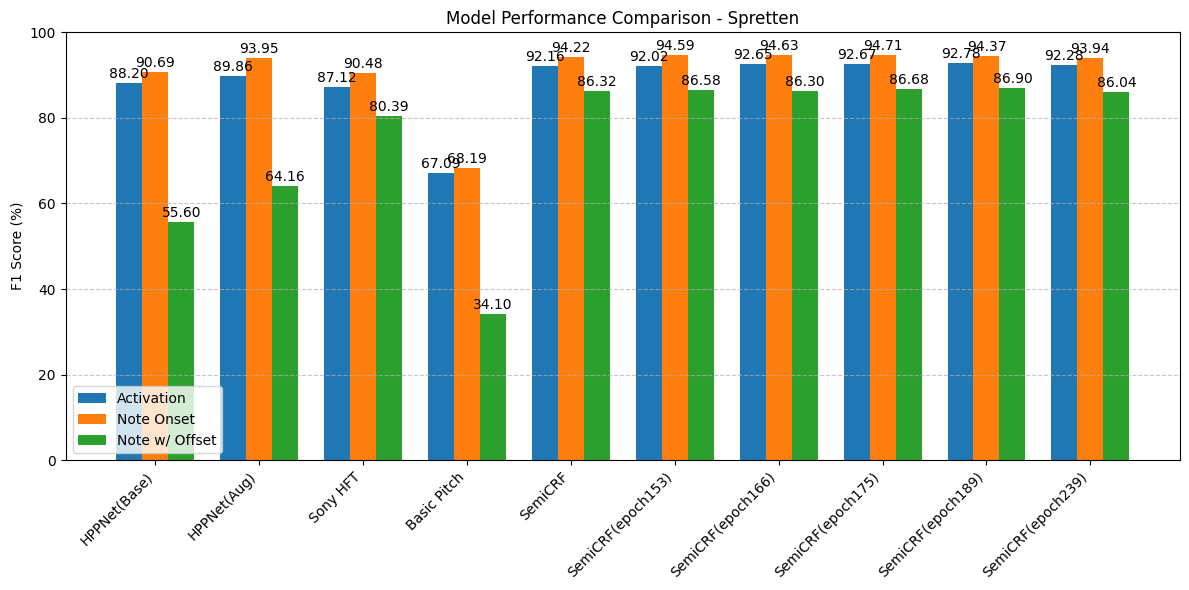

In [3]:
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import os
import mir_eval

def load_midi_notes(file_path):
    """Load MIDI file and extract note timing and pitch information."""
    midi_data = pretty_midi.PrettyMIDI(file_path)

    notes = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            notes.append((note.start, note.end, note.pitch, note.velocity))

    if not notes:
        return np.array([]), np.array([]), np.array([])

    # Sort by onset time
    notes.sort(key=lambda x: x[0])
    intervals = np.array([[note[0], note[1]] for note in notes])
    pitches = np.array([note[2] for note in notes])
    velocities = np.array([note[3] for note in notes])

    return intervals, pitches, velocities

def compute_frame_metrics(ref_intervals, ref_pitches, est_intervals, est_pitches):
    """Compute framewise metrics using piano roll representation."""
    STEP = 0.01  # 10ms step size
    MAX_MIDI = 108
    MIN_MIDI = 21

    # Get max time
    max_time = max(np.max(ref_intervals[:, 1]) if len(ref_intervals) > 0 else 0,
                   np.max(est_intervals[:, 1]) if len(est_intervals) > 0 else 0)
    times = np.arange(0, max_time, STEP)

    # Initialize piano rolls
    ref_roll = np.zeros((len(times), MAX_MIDI - MIN_MIDI + 1))
    est_roll = np.zeros((len(times), MAX_MIDI - MIN_MIDI + 1))

    # Fill in reference piano roll
    for interval, pitch in zip(ref_intervals, ref_pitches):
        if MIN_MIDI <= pitch <= MAX_MIDI:
            start_idx = int(interval[0] / STEP)
            end_idx = int(interval[1] / STEP)
            pitch_idx = int(pitch - MIN_MIDI)
            ref_roll[start_idx:end_idx, pitch_idx] = 1

    # Fill in estimated piano roll
    for interval, pitch in zip(est_intervals, est_pitches):
        if MIN_MIDI <= pitch <= MAX_MIDI:
            start_idx = int(interval[0] / STEP)
            end_idx = int(interval[1] / STEP)
            pitch_idx = int(pitch - MIN_MIDI)
            est_roll[start_idx:end_idx, pitch_idx] = 1

    # Compute intersection
    correct = np.sum(np.logical_and(ref_roll == 1, est_roll == 1))
    n_ref = np.sum(ref_roll == 1)
    n_est = np.sum(est_roll == 1)

    precision = correct / (n_est + 1e-8)
    recall = correct / (n_ref + 1e-8)
    f_measure = 2 * precision * recall / (precision + recall + 1e-8)

    return precision, recall, f_measure

def evaluate_transcription(reference_file, estimated_file):
    """Evaluate transcription following the paper's methodology."""
    # Load MIDI data
    ref_intervals, ref_pitches, _ = load_midi_notes(reference_file)
    est_intervals, est_pitches, _ = load_midi_notes(estimated_file)

    # Frame-based metrics
    frame_p, frame_r, frame_f = compute_frame_metrics(ref_intervals, ref_pitches,
                                                     est_intervals, est_pitches)

    # Note-based metrics (onset only)
    note_scores = mir_eval.transcription.precision_recall_f1_overlap(
        ref_intervals, ref_pitches,
        est_intervals, est_pitches,
        onset_tolerance=0.05,
        pitch_tolerance=50.0,
        offset_ratio=None
    )

    # Note with offset
    note_offset_scores = mir_eval.transcription.precision_recall_f1_overlap(
        ref_intervals, ref_pitches,
        est_intervals, est_pitches,
        onset_tolerance=0.05,
        pitch_tolerance=50.0,
        offset_ratio=0.2,
        offset_min_tolerance=0.05
    )

    return {
        'frame': {'Precision': frame_p, 'Recall': frame_r, 'F-measure': frame_f},
        'note': {'Precision': note_scores[0], 'Recall': note_scores[1], 'F-measure': note_scores[2]},
        'note+offset': {'Precision': note_offset_scores[0], 'Recall': note_offset_scores[1], 'F-measure': note_offset_scores[2]}
    }

def plot_model_comparison(results):
    """Plot F1 scores comparison between models."""
    metric_types = ['frame', 'note', 'note+offset']
    metric_names = ['Activation', 'Note Onset', 'Note w/ Offset']

    num_models = len(results)
    num_metrics = len(metric_types)
    x = np.arange(num_models)
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, metric in enumerate(metric_types):
        f1_scores = [results[model][metric]['F-measure'] * 100 for model in results.keys()]
        ax.bar(x + i*width, f1_scores, width, label=metric_names[i])

        # Add value labels
        for j, score in enumerate(f1_scores):
            ax.text(x[j] + i*width, score + 0.5, f'{score:.2f}',
                    ha='center', va='bottom')

    ax.set_ylabel('F1 Score (%)')
    ax.set_title('Model Performance Comparison - Spretten')
    ax.set_xticks(x + width)
    ax.set_xticklabels(list(results.keys()), rotation=45, ha='right')
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def main():
    # Configuration
    REFERENCE_FILE = "AMT-evaluation/midi-files/Spretten_original.mid"

    MODEL_CONFIGS = {
        "HPPNet(Base)": "AMT-evaluation/midi-files/runs/transcriber-230207-224701_nozzle/model-99000_evaluate/MAESTRO/test/Spretten_original.flac'.pred.mid",
        "HPPNet(Aug)": "AMT-evaluation/midi-files/runs/transcriber-230429-124319_bombs/model-60000_evaluate/MAESTRO/test/Spretten_original.flac'.pred.mid",
        "Sony HFT": "AMT-evaluation/midi-files/Spretten_original_transcribedsony004001.mid",
        "Basic Pitch": "AMT-evaluation/midi-files/Spretten_basic_pitch_transcription.mid",
        "SemiCRF": "AMT-evaluation/midi-files/Spretten_original_transcribed_transkun.mid",
        "SemiCRF(epoch153)": "AMT-evaluation/midi-files/Spretten_original_transkun153.mid",
        "SemiCRF(epoch166)": "AMT-evaluation/midi-files/Spretten_original_transkun166.mid",
        "SemiCRF(epoch175)": "AMT-evaluation/midi-files/Spretten_original_transkun175.mid",
        "SemiCRF(epoch189)": "AMT-evaluation/midi-files/Spretten_original_transkun189.mid",
        "SemiCRF(epoch239)": "AMT-evaluation/midi-files/Spretten_original_transkun239.mid"
    }

    # Fixed chronological order
    model_order = [
        "HPPNet(Base)",
        "HPPNet(Aug)",
        "Sony HFT",
        "Basic Pitch",
        "SemiCRF",
        "SemiCRF(epoch153)",
        "SemiCRF(epoch166)",
        "SemiCRF(epoch175)",
        "SemiCRF(epoch189)",
        "SemiCRF(epoch239)"

    ]

    # Store results
    all_results = {}

    # Evaluate each model
    for model_name, test_file in MODEL_CONFIGS.items():
        try:
            scores = evaluate_transcription(REFERENCE_FILE, test_file)
            all_results[model_name] = scores
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            continue

    # Find best scores
    best_scores = {
        'frame': {'Precision': 0, 'Recall': 0, 'F-measure': 0},
        'note': {'Precision': 0, 'Recall': 0, 'F-measure': 0},
        'note+offset': {'Precision': 0, 'Recall': 0, 'F-measure': 0}
    }

    for metrics in all_results.values():
        for metric_type in metrics:
            for score_type in metrics[metric_type]:
                best_scores[metric_type][score_type] = max(
                    best_scores[metric_type][score_type],
                    metrics[metric_type][score_type]
                )

    # Print results table
    headers = [
        "Model".ljust(20),
        "Activation".center(18),
        "Note Onset".center(18),
        "Note w/ Offset".center(18)
    ]
    print(" | ".join(headers))
    metric_subheaders = "P(%)".center(6) + "R(%)".center(6) + "F1(%)".center(6)
    print(" | ".join([" " * 20] + [metric_subheaders] * 3))
    print("-" * 84)

    # Print models in chronological order with highlighted best scores
    for model_name in model_order:
        if model_name not in all_results:
            continue

        metrics = all_results[model_name]
        row = [model_name.ljust(20)]

        for metric_type in ['frame', 'note', 'note+offset']:
            results = metrics[metric_type]
            metric_str = ""
            for score_type in ['Precision', 'Recall', 'F-measure']:
                value = results[score_type] * 100
                if abs(value - best_scores[metric_type][score_type] * 100) < 0.01:
                    metric_str += f"\033[92m{value:6.2f}\033[0m"
                else:
                    metric_str += f"{value:6.2f}"
            row.append(metric_str)

        print(" | ".join(row))

    # Plot comparison
    plot_model_comparison(all_results)

if __name__ == "__main__":
    main()

# Godværsdagen f1 scores

Model                |     Activation     |     Note Onset     |   Note w/ Offset  
                     |  P(%)  R(%) F1(%)  |  P(%)  R(%) F1(%)  |  P(%)  R(%) F1(%) 
-----------------------------------------------------------------------------------
HPPNet Base          |  94.46 87.80 91.01 |  91.43 98.04 94.62 |  64.14 68.78 66.38
HPPNet Augmented     |  94.59 87.55 90.94 |  90.31 97.32 93.69 |  64.49 69.49 66.90
Sony HFT             |  94.54 90.77 92.62 |  94.49 97.86 96.14 |  87.60 90.72 89.13
SemiCRF              |  94.50 94.44 94.47 |  94.61 97.15 95.86 |  89.75 92.15 90.93
SemiCRF(Epoch152)    |  94.72 93.95 94.33 |  94.01 97.95 95.94 |  89.13 92.86 90.96
SemiCRF(Epoch166)    |  94.99 93.77 94.37 |  94.17 97.95 96.02 |  89.02 92.60 90.77
SemiCRF(Epoch175)    |  94.14 93.56 93.85 |  94.40 97.68 96.01 |  88.79 91.88 90.31
SemiCRF(Epoch189)    |  95.03 93.71 94.36 |  94.07 97.68 95.84 |  88.92 92.33 90.59
SemiCRF(Epoch239)    |  94.58 93.43 94.00 |  93.91 97.59 95.71 |  88.50 91.9

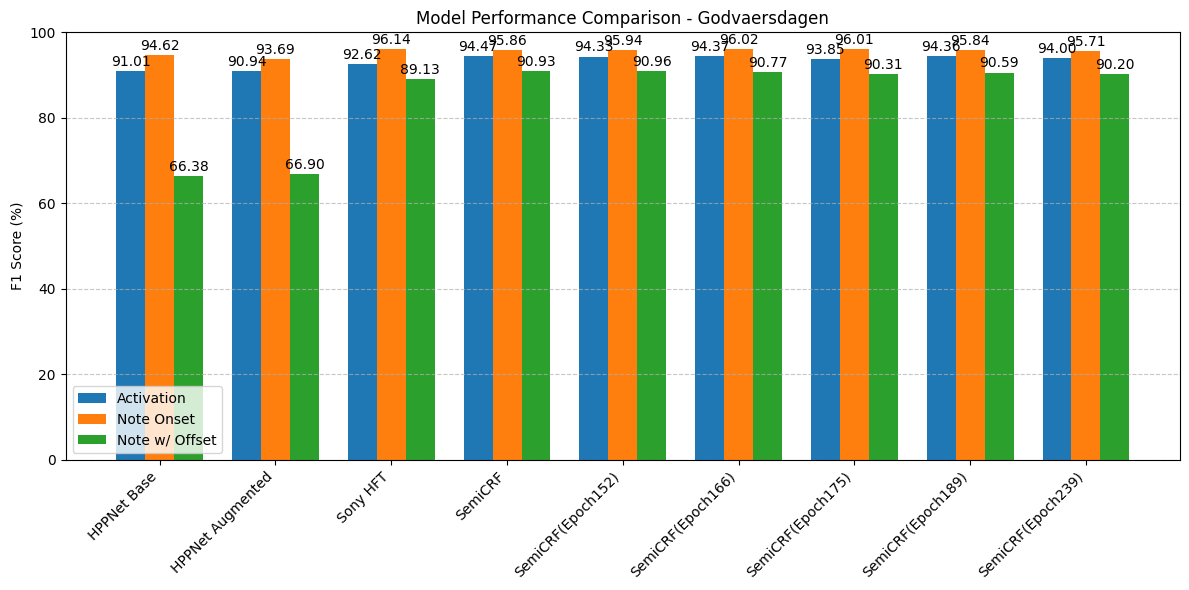

In [4]:
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import os
import mir_eval

def load_midi_notes(file_path):
    """Load MIDI file and extract note timing and pitch information."""
    midi_data = pretty_midi.PrettyMIDI(file_path)

    notes = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            notes.append((note.start, note.end, note.pitch, note.velocity))

    if not notes:
        return np.array([]), np.array([]), np.array([])

    # Sort by onset time
    notes.sort(key=lambda x: x[0])
    intervals = np.array([[note[0], note[1]] for note in notes])
    pitches = np.array([note[2] for note in notes])
    velocities = np.array([note[3] for note in notes])

    return intervals, pitches, velocities

def compute_frame_metrics(ref_intervals, ref_pitches, est_intervals, est_pitches):
    """Compute framewise metrics using piano roll representation."""
    STEP = 0.01  # 10ms step size
    MAX_MIDI = 108
    MIN_MIDI = 21

    # Get max time
    max_time = max(np.max(ref_intervals[:, 1]) if len(ref_intervals) > 0 else 0,
                   np.max(est_intervals[:, 1]) if len(est_intervals) > 0 else 0)
    times = np.arange(0, max_time, STEP)

    # Initialize piano rolls
    ref_roll = np.zeros((len(times), MAX_MIDI - MIN_MIDI + 1))
    est_roll = np.zeros((len(times), MAX_MIDI - MIN_MIDI + 1))

    # Fill in reference piano roll
    for interval, pitch in zip(ref_intervals, ref_pitches):
        if MIN_MIDI <= pitch <= MAX_MIDI:
            start_idx = int(interval[0] / STEP)
            end_idx = int(interval[1] / STEP)
            pitch_idx = int(pitch - MIN_MIDI)
            ref_roll[start_idx:end_idx, pitch_idx] = 1

    # Fill in estimated piano roll
    for interval, pitch in zip(est_intervals, est_pitches):
        if MIN_MIDI <= pitch <= MAX_MIDI:
            start_idx = int(interval[0] / STEP)
            end_idx = int(interval[1] / STEP)
            pitch_idx = int(pitch - MIN_MIDI)
            est_roll[start_idx:end_idx, pitch_idx] = 1

    # Compute intersection
    correct = np.sum(np.logical_and(ref_roll == 1, est_roll == 1))
    n_ref = np.sum(ref_roll == 1)
    n_est = np.sum(est_roll == 1)

    precision = correct / (n_est + 1e-8)
    recall = correct / (n_ref + 1e-8)
    f_measure = 2 * precision * recall / (precision + recall + 1e-8)

    return precision, recall, f_measure

def evaluate_transcription(reference_file, estimated_file):
    """Evaluate transcription following the paper's methodology."""
    # Load MIDI data
    ref_intervals, ref_pitches, _ = load_midi_notes(reference_file)
    est_intervals, est_pitches, _ = load_midi_notes(estimated_file)

    # Frame-based metrics
    frame_p, frame_r, frame_f = compute_frame_metrics(ref_intervals, ref_pitches,
                                                     est_intervals, est_pitches)

    # Note-based metrics (onset only)
    note_scores = mir_eval.transcription.precision_recall_f1_overlap(
        ref_intervals, ref_pitches,
        est_intervals, est_pitches,
        onset_tolerance=0.05,
        pitch_tolerance=50.0,
        offset_ratio=None
    )

    # Note with offset
    note_offset_scores = mir_eval.transcription.precision_recall_f1_overlap(
        ref_intervals, ref_pitches,
        est_intervals, est_pitches,
        onset_tolerance=0.05,
        pitch_tolerance=50.0,
        offset_ratio=0.2,
        offset_min_tolerance=0.05
    )

    return {
        'frame': {'Precision': frame_p, 'Recall': frame_r, 'F-measure': frame_f},
        'note': {'Precision': note_scores[0], 'Recall': note_scores[1], 'F-measure': note_scores[2]},
        'note+offset': {'Precision': note_offset_scores[0], 'Recall': note_offset_scores[1], 'F-measure': note_offset_scores[2]}
    }

def plot_model_comparison(results):
    """Plot F1 scores comparison between models."""
    metric_types = ['frame', 'note', 'note+offset']
    metric_names = ['Activation', 'Note Onset', 'Note w/ Offset']

    num_models = len(results)
    num_metrics = len(metric_types)
    x = np.arange(num_models)
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, metric in enumerate(metric_types):
        f1_scores = [results[model][metric]['F-measure'] * 100 for model in results.keys()]
        ax.bar(x + i*width, f1_scores, width, label=metric_names[i])

        # Add value labels
        for j, score in enumerate(f1_scores):
            ax.text(x[j] + i*width, score + 0.5, f'{score:.2f}',
                    ha='center', va='bottom')

    ax.set_ylabel('F1 Score (%)')
    ax.set_title('Model Performance Comparison - Godvaersdagen')
    ax.set_xticks(x + width)
    ax.set_xticklabels(list(results.keys()), rotation=45, ha='right')
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def main():
    # Configuration
    REFERENCE_FILE = "AMT-evaluation/midi-files/Godvaersdagen_original1.mid"

    MODEL_CONFIGS = {
        "HPPNet Base": "AMT-evaluation/midi-files/runs/transcriber-230425-011304_year/model-60000_evaluate/MAESTRO/test/Godvaersdagen_original1.flac'.pred.mid",
        "HPPNet Augmented": "AMT-evaluation/midi-files/runs/transcriber-230429-124319_bombs/model-60000_evaluate/MAESTRO/test/Godvaersdagen_original1.flac'.pred.mid",
        "Sony HFT": "AMT-evaluation/midi-files/Godvaersdagen_original_transcribedsony004001.mid",
        "SemiCRF": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun.mid",
        "SemiCRF(Epoch152)": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun153.mid",
        "SemiCRF(Epoch166)": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun166.mid",
        "SemiCRF(Epoch175)": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun175.mid",
        "SemiCRF(Epoch189)": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun189.mid",
        "SemiCRF(Epoch239)": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun239.mid"

    }

    # Fixed chronological order
    model_order = ["HPPNet Base", "HPPNet Augmented", "Sony HFT", "SemiCRF", "SemiCRF(Epoch152)","SemiCRF(Epoch166)","SemiCRF(Epoch175)", "SemiCRF(Epoch189)", "SemiCRF(Epoch239)"]

    # Store results
    all_results = {}

    # Evaluate each model
    for model_name, test_file in MODEL_CONFIGS.items():
        try:
            scores = evaluate_transcription(REFERENCE_FILE, test_file)
            all_results[model_name] = scores
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            continue

    # Find best scores
    best_scores = {
        'frame': {'Precision': 0, 'Recall': 0, 'F-measure': 0},
        'note': {'Precision': 0, 'Recall': 0, 'F-measure': 0},
        'note+offset': {'Precision': 0, 'Recall': 0, 'F-measure': 0}
    }

    for metrics in all_results.values():
        for metric_type in metrics:
            for score_type in metrics[metric_type]:
                best_scores[metric_type][score_type] = max(
                    best_scores[metric_type][score_type],
                    metrics[metric_type][score_type]
                )

    # Print results table
    headers = [
        "Model".ljust(20),
        "Activation".center(18),
        "Note Onset".center(18),
        "Note w/ Offset".center(18)
    ]
    print(" | ".join(headers))
    metric_subheaders = "P(%)".center(6) + "R(%)".center(6) + "F1(%)".center(6)
    print(" | ".join([" " * 20] + [metric_subheaders] * 3))
    print("-" * 83)

    # Print models in chronological order with highlighted best scores
    for model_name in model_order:
        if model_name not in all_results:
            continue

        metrics = all_results[model_name]
        row = [model_name.ljust(20)]

        for metric_type in ['frame', 'note', 'note+offset']:
            results = metrics[metric_type]
            metric_str = ""
            for score_type in ['Precision', 'Recall', 'F-measure']:
                value = results[score_type] * 100
                if abs(value - best_scores[metric_type][score_type] * 100) < 0.01:
                    metric_str += f"\033[92m{value:6.2f}\033[0m"
                else:
                    metric_str += f"{value:6.2f}"
            row.append(metric_str)

        print(" | ".join(row))

    # Plot comparison
    plot_model_comparison(all_results)

if __name__ == "__main__":
    main()

# Combined F1 scores for Spretten & Godværsdagen

Model                |     Activation     |     Note Onset     |   Note w/ Offset  
                     |  P(%)  R(%) F1(%)  |  P(%)  R(%) F1(%)  |  P(%)  R(%) F1(%) 
-----------------------------------------------------------------------------------
HPPNet Base          |  92.60 86.80 89.60 |  90.16 95.30 92.65 |  59.32 62.76 60.99
HPPNet Augmented     |  93.79 87.25 90.40 |  92.63 95.15 93.82 |  64.66 66.50 65.53
Sony HFT             |  91.79 88.03 89.87 |  93.26 93.42 93.31 |  84.68 84.89 84.76
SemiCRF              |  92.94 93.70 93.32 |  95.57 94.58 95.04 |  89.09 88.22 88.63
SemiCRF153           |  93.19 93.17 93.18 |  95.28 95.32 95.26 |  88.75 88.86 88.77
SemiCRF166           |  93.69 93.34 93.51 |  95.63 95.12 95.33 |  88.79 88.38 88.54
SemiCRF175           |  93.19 93.33 93.26 |  95.68 95.12 95.36 |  88.77 88.30 88.50
SemiCRF189           |  93.53 93.63 93.57 |  95.31 94.98 95.10 |  88.91 88.66 88.75
SemiCRF239           |  93.18 93.10 93.14 |  95.07 94.66 94.82 |  88.32 88.0

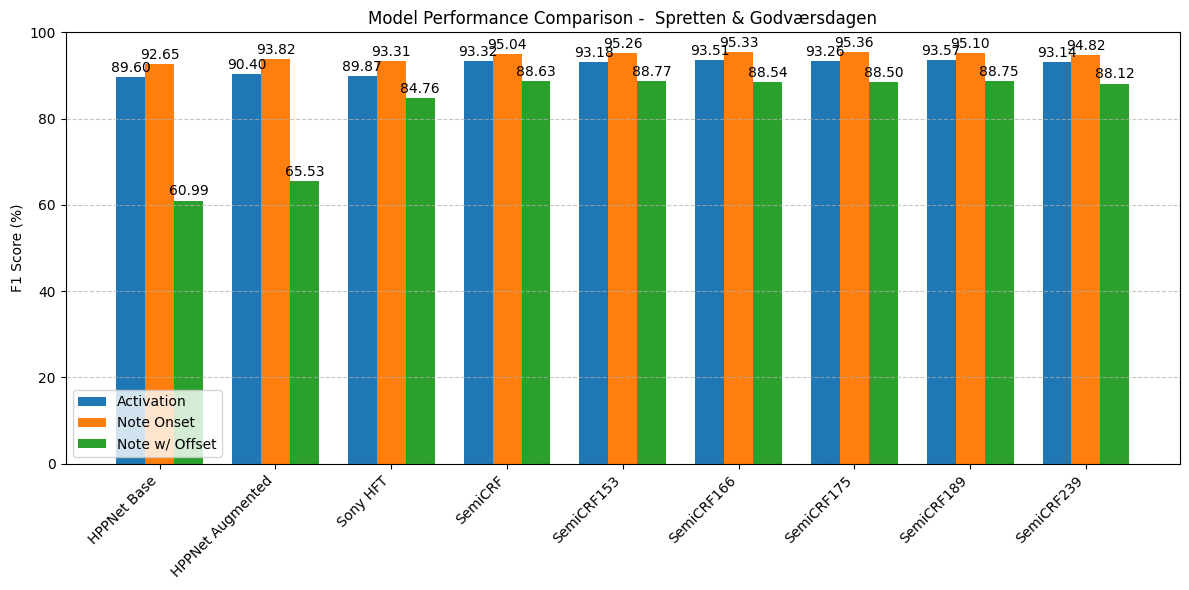

In [5]:
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import os
import mir_eval

def load_midi_notes(file_path):
    """Load MIDI file and extract note timing, pitch, and velocity information."""
    midi_data = pretty_midi.PrettyMIDI(file_path)

    notes = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            notes.append((note.start, note.end, note.pitch, note.velocity))

    if not notes:
        return np.array([]), np.array([]), np.array([])

    # Sort by onset time
    notes.sort(key=lambda x: x[0])
    intervals = np.array([[note[0], note[1]] for note in notes])
    pitches = np.array([note[2] for note in notes])
    velocities = np.array([note[3] for note in notes])

    return intervals, pitches, velocities

def compute_frame_metrics(ref_intervals, ref_pitches, est_intervals, est_pitches):
    """Compute framewise metrics using piano roll representation."""
    # Create piano roll representation (10ms resolution)
    STEP = 0.01  # 10ms step size
    MAX_MIDI = 108
    MIN_MIDI = 21

    # Get max time
    max_time = max(np.max(ref_intervals[:, 1]) if len(ref_intervals) > 0 else 0,
                   np.max(est_intervals[:, 1]) if len(est_intervals) > 0 else 0)
    times = np.arange(0, max_time, STEP)

    # Initialize piano rolls
    ref_roll = np.zeros((len(times), MAX_MIDI - MIN_MIDI + 1))
    est_roll = np.zeros((len(times), MAX_MIDI - MIN_MIDI + 1))

    # Fill in reference piano roll
    for interval, pitch in zip(ref_intervals, ref_pitches):
        if MIN_MIDI <= pitch <= MAX_MIDI:
            start_idx = int(interval[0] / STEP)
            end_idx = int(interval[1] / STEP)
            pitch_idx = int(pitch - MIN_MIDI)
            ref_roll[start_idx:end_idx, pitch_idx] = 1

    # Fill in estimated piano roll
    for interval, pitch in zip(est_intervals, est_pitches):
        if MIN_MIDI <= pitch <= MAX_MIDI:
            start_idx = int(interval[0] / STEP)
            end_idx = int(interval[1] / STEP)
            pitch_idx = int(pitch - MIN_MIDI)
            est_roll[start_idx:end_idx, pitch_idx] = 1

    # Compute intersection
    correct = np.sum(np.logical_and(ref_roll == 1, est_roll == 1))
    n_ref = np.sum(ref_roll == 1)
    n_est = np.sum(est_roll == 1)

    precision = correct / (n_est + 1e-8)
    recall = correct / (n_ref + 1e-8)
    f_measure = 2 * precision * recall / (precision + recall + 1e-8)

    return precision, recall, f_measure

def plot_model_comparison(results):
    """Plot F1 scores comparison between models."""
    metric_types = ['frame', 'note', 'note+offset']
    metric_names = ['Activation', 'Note Onset', 'Note w/ Offset']

    num_models = len(results)
    num_metrics = len(metric_types)
    x = np.arange(num_models)
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, metric in enumerate(metric_types):
        f1_scores = [results[model][metric]['F-measure'] * 100 for model in results.keys()]
        ax.bar(x + i*width, f1_scores, width, label=metric_names[i])

        # Add value labels
        for j, score in enumerate(f1_scores):
            ax.text(x[j] + i*width, score + 0.5, f'{score:.2f}',
                    ha='center', va='bottom')

    ax.set_ylabel('F1 Score (%)')
    ax.set_title('Model Performance Comparison -  Spretten & Godværsdagen')
    ax.set_xticks(x + width)
    ax.set_xticklabels(list(results.keys()), rotation=45, ha='right')
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def evaluate_transcription(reference_file, estimated_file):
    """Evaluate transcription following the paper's methodology."""
    # Load MIDI data
    ref_intervals, ref_pitches, ref_velocities = load_midi_notes(reference_file)
    est_intervals, est_pitches, est_velocities = load_midi_notes(estimated_file)

    # Frame-based metrics
    frame_p, frame_r, frame_f = compute_frame_metrics(ref_intervals, ref_pitches,
                                                     est_intervals, est_pitches)

    # Note-based metrics (onset only)
    note_scores = mir_eval.transcription.precision_recall_f1_overlap(
        ref_intervals, ref_pitches,
        est_intervals, est_pitches,
        onset_tolerance=0.05,
        pitch_tolerance=50.0,
        offset_ratio=None
    )

    # Note with offset
    note_offset_scores = mir_eval.transcription.precision_recall_f1_overlap(
        ref_intervals, ref_pitches,
        est_intervals, est_pitches,
        onset_tolerance=0.05,
        pitch_tolerance=50.0,
        offset_ratio=0.2,
        offset_min_tolerance=0.05
    )


    return {
        'frame': {'Precision': frame_p, 'Recall': frame_r, 'F-measure': frame_f},
        'note': {'Precision': note_scores[0], 'Recall': note_scores[1], 'F-measure': note_scores[2]},
        'note+offset': {'Precision': note_offset_scores[0], 'Recall': note_offset_scores[1], 'F-measure': note_offset_scores[2]}
    }

def main():
    # Configuration
    REFERENCE_FILES = {
        "godvaer": "AMT-evaluation/midi-files/Godvaersdagen_original1.mid",
        "spretten": "AMT-evaluation/midi-files/Spretten_original.mid"
    }

    MODEL_CONFIGS = {
        "HPPNet Base": {
            "godvaer": "AMT-evaluation/midi-files/runs/transcriber-230425-011304_year/model-60000_evaluate/MAESTRO/test/Godvaersdagen_original1.flac'.pred.mid",
            "spretten": "AMT-evaluation/midi-files//runs/transcriber-230207-224701_nozzle/model-99000_evaluate/MAESTRO/test/Spretten_original.flac'.pred.mid"
        },
        "HPPNet Augmented": {
            "godvaer": "AMT-evaluation/midi-files/runs/transcriber-230429-124319_bombs/model-60000_evaluate/MAESTRO/test/Godvaersdagen_original1.flac'.pred.mid",
            "spretten": "AMT-evaluation/midi-files/runs/transcriber-230429-124319_bombs/model-60000_evaluate/MAESTRO/test/Spretten_original.flac'.pred.mid"
        },
        "Sony HFT": {
            "godvaer": "AMT-evaluation/midi-files/Godvaersdagen_original_transcribedsony004001.mid",
            "spretten": "AMT-evaluation/midi-files/Spretten_original_transcribedsony004001.mid"
        },
        "SemiCRF": {
            "godvaer": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun.mid",
            "spretten": "AMT-evaluation/midi-files/Spretten_original_transcribed_transkun.mid"
        },
        "SemiCRF153": {
            "godvaer": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun153.mid",
            "spretten": "AMT-evaluation/midi-files/Spretten_original_transkun153.mid"
        },
        "SemiCRF166": {
            "godvaer": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun166.mid",
            "spretten": "AMT-evaluation/midi-files/Spretten_original_transkun166.mid"
        },
        "SemiCRF175": {
            "godvaer": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun175.mid",
            "spretten": "AMT-evaluation/midi-files/Spretten_original_transkun175.mid"
    },
        "SemiCRF189": {
            "godvaer": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun189.mid",
            "spretten": "AMT-evaluation/midi-files/Spretten_original_transkun189.mid"
    },
        "SemiCRF239": {
            "godvaer": "AMT-evaluation/midi-files/Godvaersdagen_original1_transkun239.mid",
            "spretten": "AMT-evaluation/midi-files/Spretten_original_transkun239.mid"
    }
     }

    # Fixed chronological order
    model_order = ["HPPNet Base", "HPPNet Augmented", "Sony HFT", "SemiCRF", "SemiCRF153", "SemiCRF166", "SemiCRF175","SemiCRF189","SemiCRF239" ]

    # Store results
    all_results = {}

    # Evaluate each model
    for model_name, files in MODEL_CONFIGS.items():
        metrics = {}
        for piece, test_file in files.items():
            try:
                scores = evaluate_transcription(REFERENCE_FILES[piece], test_file)
                if not metrics:
                    metrics = scores
                else:
                    for metric_type in scores:
                        for score_type in scores[metric_type]:
                            metrics[metric_type][score_type] = np.mean([
                                metrics[metric_type][score_type],
                                scores[metric_type][score_type]
                            ])
            except Exception as e:
                print(f"Error evaluating {model_name} on {piece}: {str(e)}")
                continue

        if metrics:
            all_results[model_name] = metrics

    # Find best scores
    best_scores = {
        'frame': {'Precision': 0, 'Recall': 0, 'F-measure': 0},
        'note': {'Precision': 0, 'Recall': 0, 'F-measure': 0},
        'note+offset': {'Precision': 0, 'Recall': 0, 'F-measure': 0}
    }

    for metrics in all_results.values():
        for metric_type in metrics:
            for score_type in metrics[metric_type]:
                best_scores[metric_type][score_type] = max(
                    best_scores[metric_type][score_type],
                    metrics[metric_type][score_type]
                )

    # Print results table
    headers = [
        "Model".ljust(20),
        "Activation".center(18),
        "Note Onset".center(18),
        "Note w/ Offset".center(18)
    ]
    print(" | ".join(headers))
    metric_subheaders = "P(%)".center(6) + "R(%)".center(6) + "F1(%)".center(6)
    print(" | ".join([" " * 20] + [metric_subheaders] * 3))
    print("-" * 83)

    # Print models in chronological order with highlighted best scores
    for model_name in model_order:
        if model_name not in all_results:
            continue

        metrics = all_results[model_name]
        row = [model_name.ljust(20)]

        for metric_type in ['frame', 'note', 'note+offset']:
            results = metrics[metric_type]
            metric_str = ""
            for score_type in ['Precision', 'Recall', 'F-measure']:
                value = results[score_type] * 100
                if abs(value - best_scores[metric_type][score_type] * 100) < 0.01:
                    metric_str += f"\033[92m{value:6.2f}\033[0m"
                else:
                    metric_str += f"{value:6.2f}"
            row.append(metric_str)

        print(" | ".join(row))

        # Plot comparison
    plot_model_comparison(all_results)

if __name__ == "__main__":
    main()